# Golf Ball Trajectory Simulation

### Importing Libraries to Begin the Notebook

In [1]:
from mpl_toolkits import mplot3d
# Important math functions and the constant pi:
from math import sin, cos, atan2, sqrt, pi
import numpy as np
# The following import statement makes the plotting library available to us. There is also a
# statement to work around a known Jupyter bug: https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
import matplotlib.pyplot as plt

### Defining Basic Functions that We've Used in Previous Notebooks

In [2]:
# computes horizontal and vertical components of a vector and returns them as a tuple
def vector_components(length, angle_in_degrees, angle_in_degrees_z):
    angle_in_radians = angle_in_degrees * pi / 180.0
    angle_in_radians_z = angle_in_degrees_z * pi / 180.0
    x_component = length * cos(angle_in_radians)
    y_component = length * sin(angle_in_radians)
    z_component = length * sin(angle_in_radians_z)
    return x_component, y_component, z_component

# get angle from components using atan2 version of arctangent function -- result is in degrees
def angle_from_components_y(x_component, y_component):
    # use the arctangent function
    angle_in_radians = atan2(y_component, x_component)  
    # we are working in degrees -- convert radians to degrees
    angle_in_degrees = angle_in_radians * 180.0 / pi
    # return the result
    return angle_in_degrees

def angle_from_components_z(x_component, z_component):
    # use the arctangent function
    angle_in_radians = atan2(z_component, x_component)  
    # we are working in degrees -- convert radians to degrees
    angle_in_degrees = angle_in_radians * 180.0 / pi
    # return the result
    return angle_in_degrees

# get length from components using Pythagorean theorem
def length_from_components(x_component, y_component):
    length = sqrt(x_component**2 + y_component**2)
    return length

### Defining Variables to Begin the Physics of Golf Ball Flight 

In [3]:
g = 9.81 #acceleration due to gravity (m/s^2)
delta_t = 0.1 #each computation in funcitions of t is 0.1 seconds apart
mass_ball = 0.04593 #mass of golf ball in kg
mass_club = 0.200 #mass of driver head in kg (on average)
initial_angle_vertical = 10.9 #The average launch angle from drivers on the PGA Tour
initial_angle_horizontal = 0 #The ball starts off moving straight (on line)
final_velocity_club = 50.5155 #This equals 113 mph, which is average club head speed with a driver on the PGA Tour
c_restitution = 0.830 #USGA defines this as the max coefficient of restitution for any club

initial_velocity_ball = final_velocity_club * (1 + c_restitution) / (1 + (mass_ball / mass_club))

initial_horizontal_velocity, initial_vertical_velocity, initial_z_velocity = vector_components(initial_velocity_ball, initial_angle_vertical, initial_angle_horizontal)


### More Variables to Compute the Lift & Drag Constants

In [4]:
radius_ball = 0.021335 #This is in meters. The diameter of a golf ball can't be smaller than 42.67mm, so we'll 
                       #use half of that value for the radius. This will help with the area calculation later
viscocity_air = 1.81 * 10**-5 
density_air = 1.225 #The density of air at sea level is set at 1.225 kg/m^3 
area_ball = pi * radius_ball **2
initial_angular_velocity_x = 2686 * 2 * pi / 60 #The average spin rate (in radians per second)
                                                #of a drive on the PGA Tour
initial_angular_velocity_z = initial_angular_velocity_x * 0.1
    
lift_constant = density_air * area_ball #this combines all the lift constants into one constant for lift 
drag_constant = density_air * area_ball #this combines all the drag constants into one constant for drag

### Spin Function

In [5]:
decline_rate = 1.0 / 15.0  #Linear declining rate for spin

def spin(time):
    current_angular_velocity_x = initial_angular_velocity_x - decline_rate * time * initial_angular_velocity_x
    spin_factor_x = current_angular_velocity_x * radius_ball / initial_velocity_ball
    return spin_factor_x
def spin_z(time):
    current_angular_velocity_z = initial_angular_velocity_z - (decline_rate * time * initial_angular_velocity_z)
    spin_factor_z = current_angular_velocity_z * radius_ball / initial_velocity_ball

### Funcitions to Get Acceleration in Components

In [6]:
def angle_from_velocity(horizontal_velocity, vertical_velocity):
    # use the arctangent function
    angle = atan2(vertical_velocity, horizontal_velocity)  
    # we are working in degrees -- convert radians to degrees
    angle_in_degrees = angle * 180.0 / pi
    # return the result
    return angle_in_degrees

def angle_from_velocity_z(horizontal_velocity, z_velocity):
    # use the arctangent function
    angle = atan2(z_velocity, horizontal_velocity)  
    # we are working in degrees -- convert radians to degrees
    angle_in_degrees = angle * 180.0 / pi
    # return the result
    return angle_in_degrees

# get speed from components using Pythagorean theorem
def speed_from_velocity(horizontal_velocity, vertical_velocity, z_velocity):
    # pythagorean theorem
    hypotenuse = sqrt(horizontal_velocity**2 + vertical_velocity**2 + z_velocity**2)
    # return the result
    return hypotenuse

def acceleration_with_drag_and_lift(horizontal_velocity, vertical_velocity, z_velocity, time):
    
    speed = speed_from_velocity(horizontal_velocity, vertical_velocity, z_velocity)
    angle = angle_from_velocity(horizontal_velocity, vertical_velocity)
    angle_z = angle_from_velocity_z(horizontal_velocity, z_velocity)
    spin_current = spin(time) 
    acceleration_lift = 1/2 * lift_constant * c_lift * speed**2 / mass_ball
    acceleration_drag = 1/2 * drag_constant * c_drag * speed**2 / mass_ball
    horizontal_drag_component, vertical_drag_component, z_drag_component = vector_components(acceleration_drag, angle + 180, angle_z +180)
    horizontal_lift_component, vertical_lift_component, z_lift_component = vector_components(acceleration_lift, angle + 90, angle_z + 90)
    
    return horizontal_drag_component + horizontal_lift_component, vertical_drag_component + vertical_lift_component - g, z_drag_component + z_lift_component
#Since this velocity is at an angle going upwards (above the ground), the lift force acts perpendicular to that
#velocity, which applies some acceleration backwards and some acceleration upwards

#def acceleration_with_drag_and_lift_z(horizontal_velocity, vertical_velocity, z_velocity, time):
    
    #speed = speed_from_velocity(horizontal_velocity, vertical_velocity, z_velocity)
    #angle = angle_from_velocity(horizontal_velocity, z_velocity)
    #spin_current = spin_z(time) 
    #acceleration_lift = 1/2 * lift_constant * c_lift * speed**2 / mass_ball
    #acceleration_drag = 1/2 * drag_constant * c_drag * speed**2 / mass_ball
    #z_drag_component = vector_components(acceleration_drag, angle + 180)
    #z_lift_component = vector_components(acceleration_lift, angle + 90)
    
    return z_drag_component + z_lift_component

### The While-Loop that Brings it Together

In [7]:
# Initialize the x and y velocities
x_velocities = [initial_horizontal_velocity]
y_velocities = [initial_vertical_velocity]
z_velocities = [initial_z_velocity]

# Initialize the x and y positions
x_positions = [0.0]
y_positions = [0.04] # tee height
z_positions = [0.0]

# Initialize the times
times = [0.0]

#We want to go until the ball hits the ground (happens when y_position = 0)

while len(times) < 15000 and y_positions[-1] > 0:
    
    # get all the before values
    
    # velocities
    before_x_velocity = x_velocities[-1]
    before_y_velocity = y_velocities[-1]
    before_z_velocity = z_velocities[-1]
    
    # positions
    before_x_position = x_positions[-1]
    before_y_position = y_positions[-1]
    before_z_position = z_positions[-1]
    
    # time
    before_time = times[-1]
    
    
    #Defining coefficients of lift and drag, which  as a variable of the spin(time) function and re definition
    c_lift = -3.25 * spin(before_time)**2 + 1.99 * spin(before_time)
    re = speed_from_velocity(before_x_velocity, before_y_velocity, before_z_velocity) * 2 * radius_ball / viscocity_air
    
    if re > 75000:
        c_drag = (1.91 * 10**-11 * re**2) - (5.4 * 10**-6 * re) + 0.56
        
    #elif re < 75000:
        #c_drag = (1.29 * 10**-10 * re**2) - (2.59 * 10**-5 * re) + 1.50
        
    else:
        #c_drag = ((1.91 * 10**-11 * re**2) - (5.4 * 10**-6 * re) + 0.56) + ((1.29 * 10**-10 * re**2) - (2.59 * 10**-5 * re) + 1.50) / 2 
        c_drag = (1.29 * 10**-10 * re**2) - (2.59 * 10**-5 * re) + 1.50
        
    #Use the new acceleration_with_drag_and_lift function to get the accelerations. This acceleration function
    #relies on the lift and drag coefficient functions, which are also functions of other variables. 
    x_acceleration, y_acceleration, z_acceleration = acceleration_with_drag_and_lift(before_x_velocity, before_y_velocity, before_z_velocity, before_time)
    z_acceleration = z_acceleration * -0.1 #Since we're saying the z spin component is 1/10 of the backspin
                                           #components, we square it since spin_factor is squared
    # bog-standard Euler update code -- in two dimensions

    # update the x, y, and z velocities
    after_x_velocity = before_x_velocity + delta_t * x_acceleration
    after_y_velocity = before_y_velocity + delta_t * y_acceleration
    after_z_velocity = before_z_velocity + delta_t * z_acceleration
    # update the x, y, and z positions
    after_x_position = before_x_position + delta_t * before_x_velocity
    after_y_position = before_y_position + delta_t * before_y_velocity
    after_z_position = before_z_position + delta_t * before_z_velocity
    # update time
    after_time = before_time + delta_t
    
    # append all the after values to their lists
    
    x_velocities.append(after_x_velocity)
    y_velocities.append(after_y_velocity)
    z_velocities.append(after_z_velocity)
    x_positions.append(after_x_position)
    y_positions.append(after_y_position)
    z_positions.append(after_z_position)
    times.append(after_time)

### Two-Dimensional Plots

#### Horizontal Position vs. Vertical Position

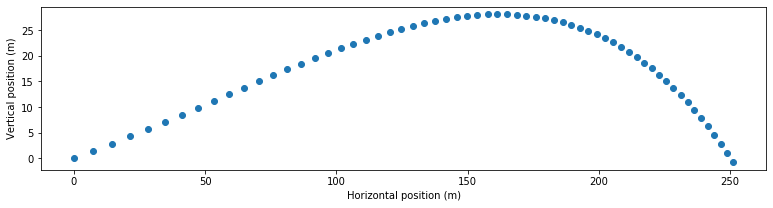

In [8]:
plt.figure(figsize=(13, 3))

plt.scatter(x_positions, y_positions)

plt.xlabel("Horizontal position (m)")
plt.ylabel("Vertical position (m)")

plt.show()

#### Horizontal Position vs. Time

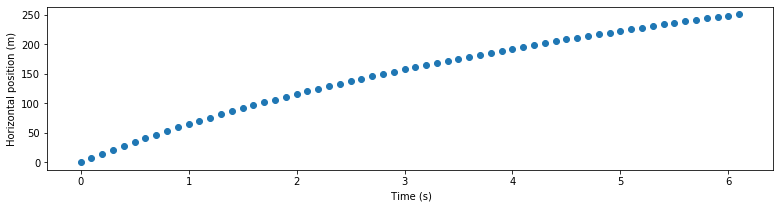

In [9]:
plt.figure(figsize=(13, 3))

plt.scatter(times, x_positions)

plt.xlabel(" Time (s)")
plt.ylabel("Horizontal position (m)")

plt.show()

#### Vertical Position vs. Time

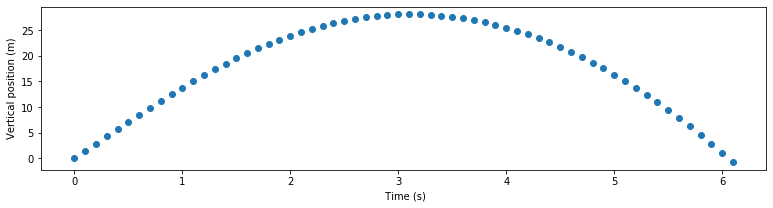

In [10]:
plt.figure(figsize=(13, 3))

plt.scatter(times, y_positions)

plt.xlabel(" Time (s)")
plt.ylabel("Vertical position (m)")

plt.show()

#### Horizontal Velocity vs. Time

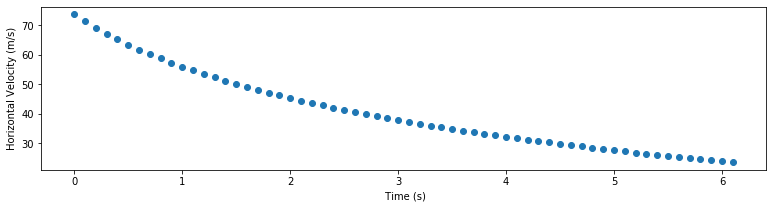

In [11]:
plt.figure(figsize=(13, 3))

plt.scatter(times, x_velocities)

plt.xlabel(" Time (s)")
plt.ylabel("Horizontal Velocity (m/s)")

plt.show()

#### Vertical Velocity vs. Time

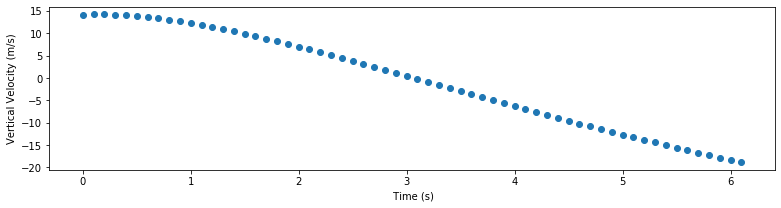

In [12]:
plt.figure(figsize=(13, 3))

plt.scatter(times, y_velocities)

plt.xlabel(" Time (s)")
plt.ylabel("Vertical Velocity (m/s)")

plt.show()

### Three-Dimensional Plots

Reference: [Good Tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)

#### X, Y, and Z Axes

(25, -25)

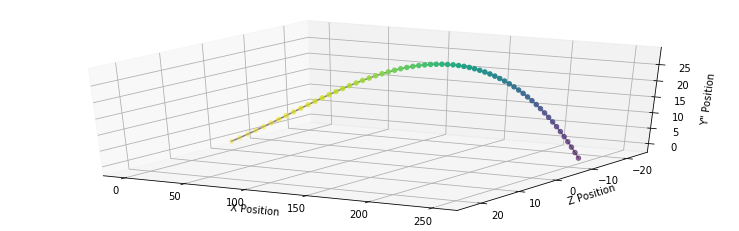

In [13]:
plt.figure(figsize=(13, 4))

ax = plt.axes(projection='3d')

ax.plot3D(x_positions, z_positions, y_positions, 'grey')

ax.scatter3D(x_positions, z_positions, y_positions, c=z_positions)

ax.set_xlabel('X Position')
ax.set_ylabel('Z Position')
ax.set_zlabel('Y" Position');

ax.set_ylim3d(25, -25)

#ax.view_init(0, 0)

#### Horizontal and Vertical Positions (X and Y Axes)

Reference: [Real Life 3D Golf Ball Trajectories](https://www.youtube.com/watch?v=9iXBIrORlqc)

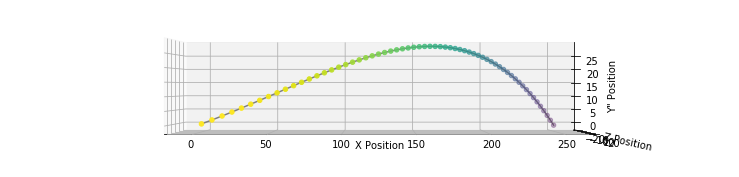

In [14]:
plt.figure(figsize=(13, 3))

ax = plt.axes(projection='3d')

ax.plot3D(x_positions, z_positions, y_positions, 'grey')

ax.scatter3D(x_positions, z_positions, y_positions, c=z_positions)

ax.set_xlabel('X Position')
ax.set_ylabel('Z Position')
ax.set_zlabel('Y" Position');

ax.set_ylim3d(25, -25)

ax.view_init(0, -90)

#### Horizontal and Sideways Positions (X and Z Axes)

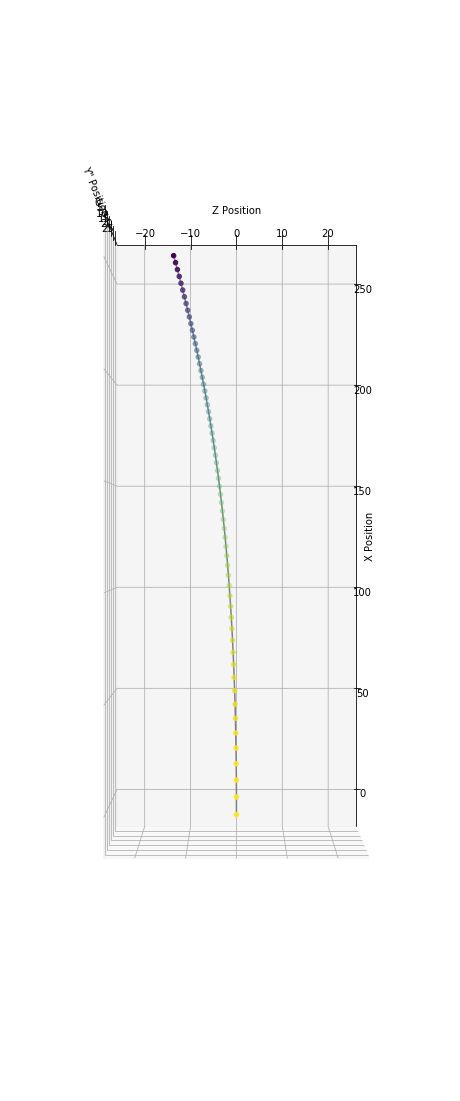

In [15]:
plt.figure(figsize=(8, 20))

ax = plt.axes(projection='3d')

ax.plot3D(x_positions, z_positions, y_positions, 'grey')

ax.scatter3D(x_positions, z_positions, y_positions, c=z_positions)

ax.set_xlabel('X Position')
ax.set_ylabel('Z Position')
ax.set_zlabel('Y" Position');

ax.set_ylim3d(-25, 25)

ax.view_init(-90, 0)

#### Vertical and Sideways Positions (Y and Z Axes)

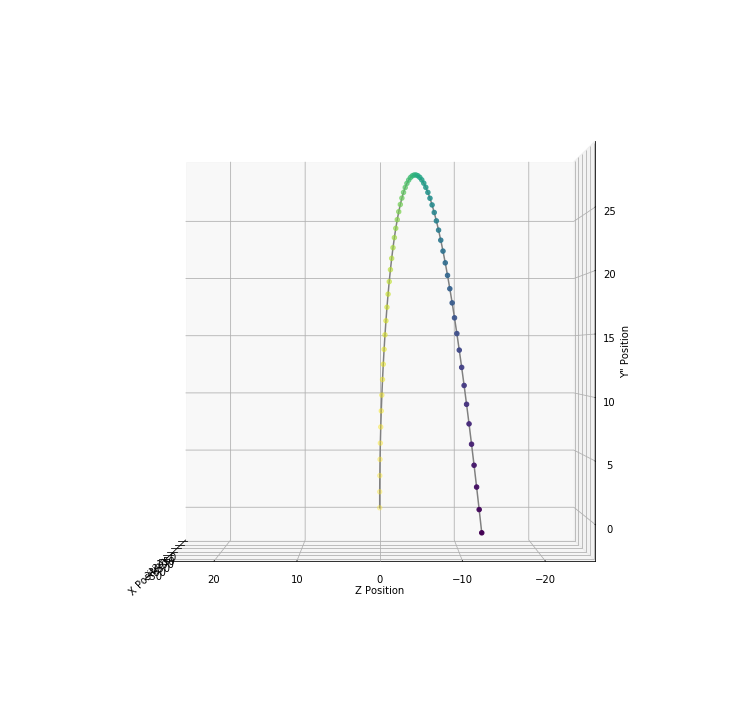

In [16]:
plt.figure(figsize=(13, 13))

ax = plt.axes(projection='3d')

ax.plot3D(x_positions, z_positions, y_positions, 'grey')

ax.scatter3D(x_positions, z_positions, y_positions, c=z_positions)

ax.set_xlabel('X Position')
ax.set_ylabel('Z Position')
ax.set_zlabel('Y" Position');

ax.set_ylim3d(25, -25)

ax.view_init(0, 0)